<a href="https://colab.research.google.com/github/DrAlexSanz/Electricity-prices/blob/main/Time_series_stationality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
data = pd.read_csv('/gdrive/MyDrive/Electricity_prices/full_data.csv', parse_dates = True)
data["time"] = pd.to_datetime(data["time"]).dt.tz_convert(None)
data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,snow_3h_Seville,clouds_all_Seville,temp_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
0,2014-12-31 23:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0.0,0,270.475,1001.0,77,1.0,62,0.0,0.0,0
1,2015-01-01 00:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0.0,0,270.475,1001.0,77,1.0,62,0.0,0.0,0
2,2015-01-01 01:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0.0,0,269.686,1002.0,78,0.0,23,0.0,0.0,0
3,2015-01-01 02:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0.0,0,269.686,1002.0,78,0.0,23,0.0,0.0,0
4,2015-01-01 03:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0.0,0,269.686,1002.0,78,0.0,23,0.0,0.0,0


## Several plots to check how the price looks like and the power generation too


*   Create a plotting function, give the df, the name of the column and it will generate the plot
*   Explore several plots.



In [ ]:
def plot_column(df, column_name, label = None, ylabel = None, title = None, start=0, end = None):
    """
    Plots a column of the weather dataframe. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    ax.plot(df[column_name][start:end], label=label)
    ax.set_ylabel(ylabel, fontsize=16)
    if ylabel:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

## Let's plot the power load in two weeks

For some reason the plot it's taking the index (date) position instead instead of the real value. I'll fix it later.

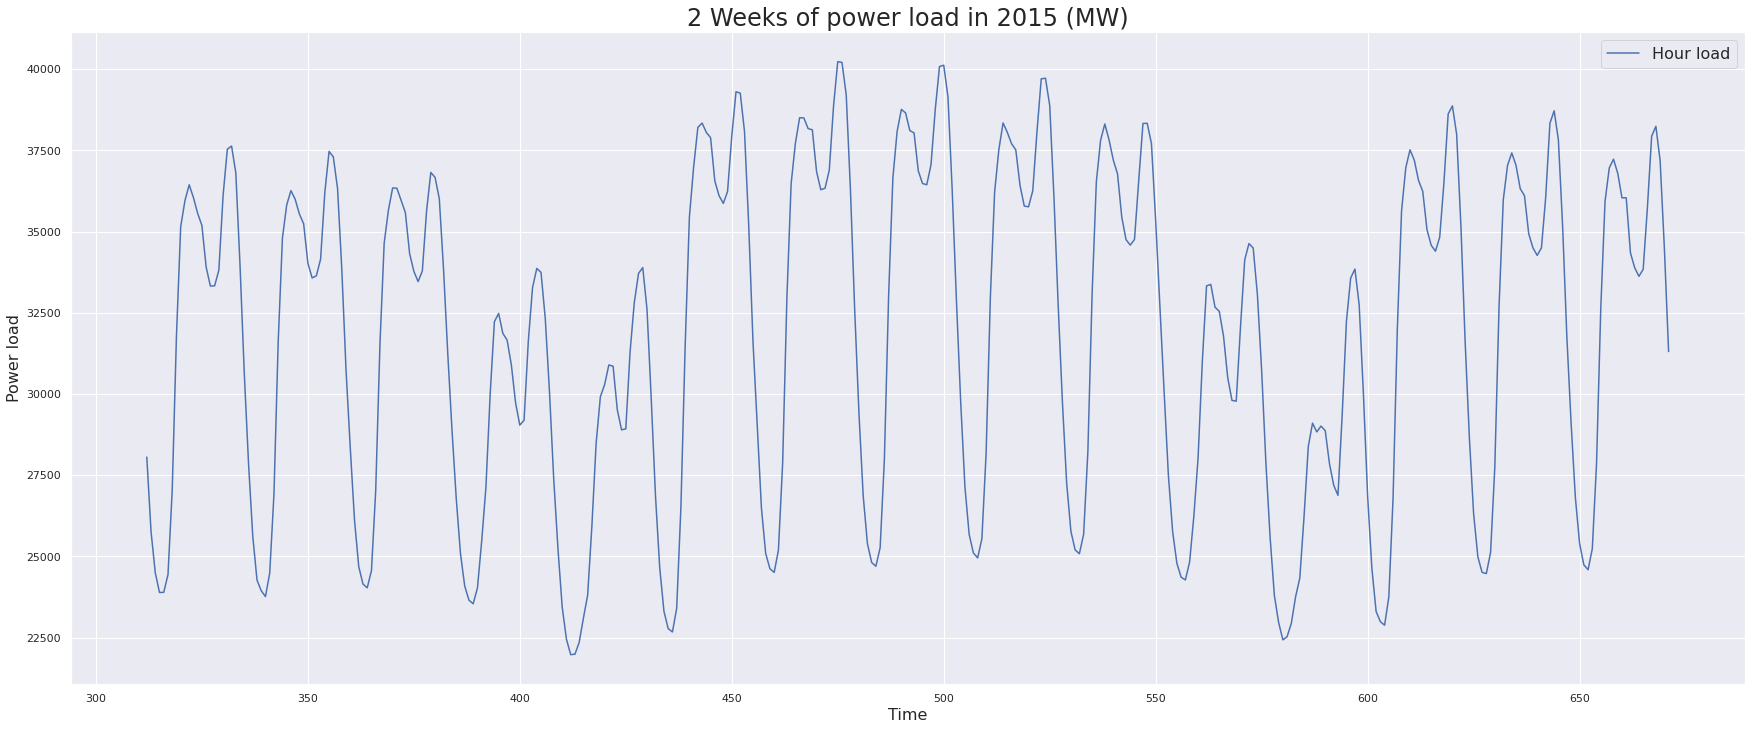

In [ ]:
ax = plot_column(data, column_name = "total load actual", label = "Hour load", ylabel = "Power load",
                 start = 13*24, end = 24 * 28,
                 title = "2 Weeks of power load in 2015 (MW)")


plt.show()

## The days look as they should look like and that is a good sign.

Check here: [Red Eléctrica](https://www.ree.es/es)

There is the usual double hump in the middle of the day (typical winter) and there is also the difference between weekdays and weekends. Days and nights are very clear. Summer will have less obvious peaks.

## Now let's plot the price and the rolling month/week mean

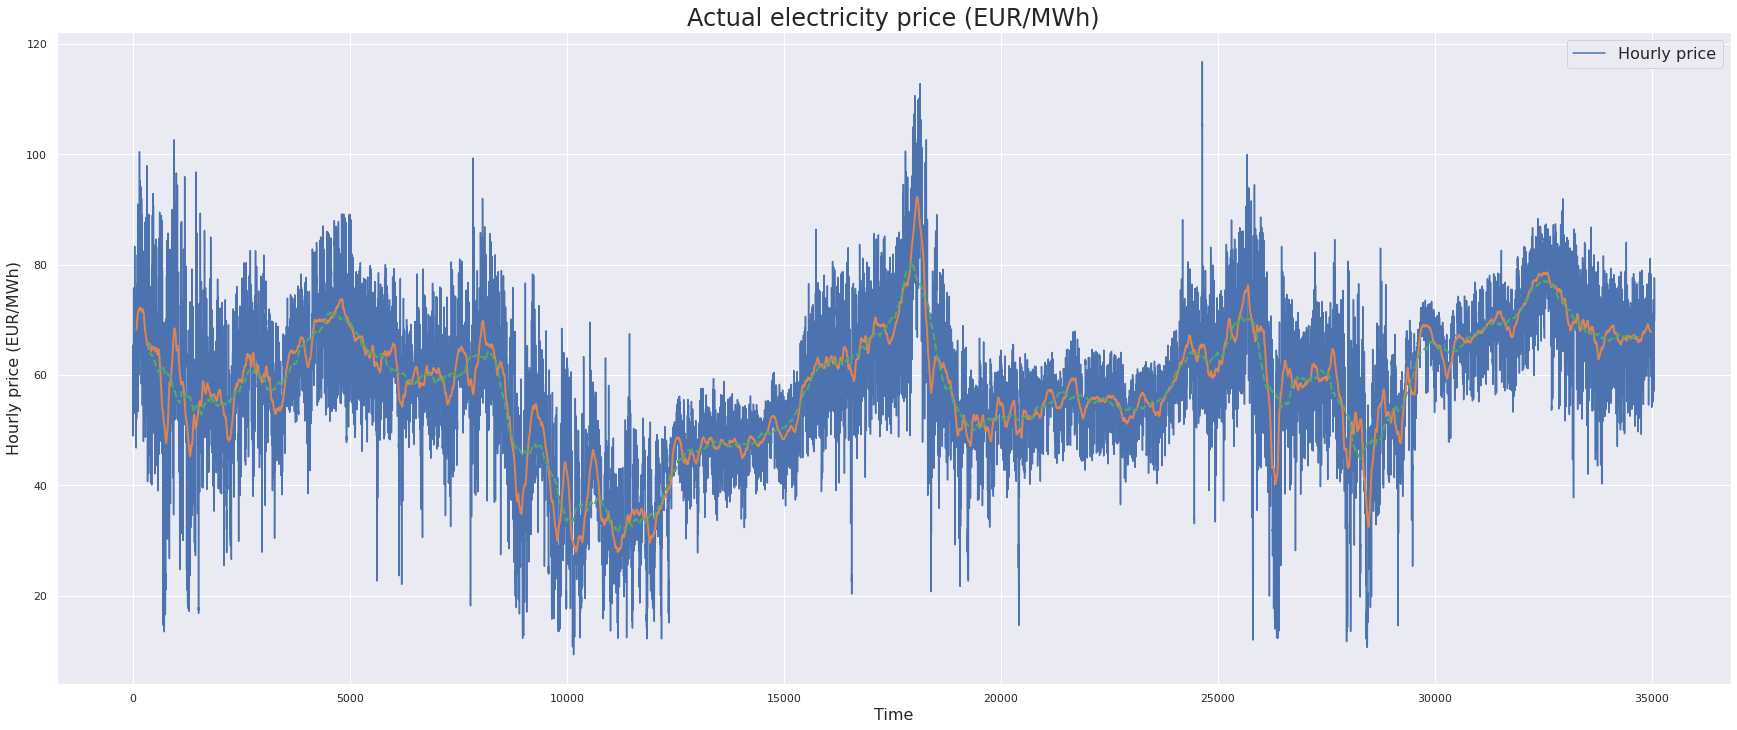

In [ ]:
rolling_week = data["price actual"].rolling(24 * 7, center = True).mean()
rolling_month = data["price actual"].rolling(24 * 30, center = True).mean()

ax = plot_column(df = data, column_name = "price actual", label = "Hourly price", ylabel = "Hourly price (EUR/MWh)",
                 title = "Actual electricity price (EUR/MWh)")
ax.plot(rolling_week, linestyle = "-", linewidth = 2, label = "Price: 1 week rolling mean")
ax.plot(rolling_month, linestyle = "--", linewidth = 2, label = "Price: 30 days rolling mean")

###Nothing weird here, apart from the axis.

### Let's have a look at the price distribution

It's a reasonably normal distribution. I can standardize it if I need to.

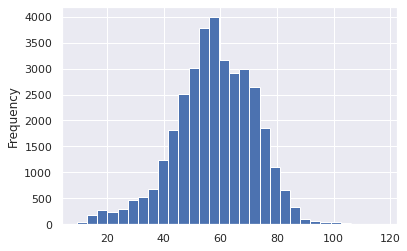

In [ ]:
hist = data["price actual"].plot.hist(bins = 30)

### Check if the series is stationary or not.

* Apparently there is a bug in seasonal_decompose. The way to work around it is to use the freq parameter and setting it to a reasonable value (I have hourly data and I know that electricity prices should be periodic every day).

* Setting freq to 1 gives 0 residuals (the model didn't capture any variation in my series.
* setting freq to a huge number, like 2400 gives a wrong decomposition (it's like doing a 3 month rolling window).

[GitHub Issue](https://github.com/statsmodels/statsmodels/issues/3503)

* Also possible to use a multiplicative model but I understand it less

* In this case I can see that there is no seasonality apparent. I will do more tests below.


<function matplotlib.pyplot.show>

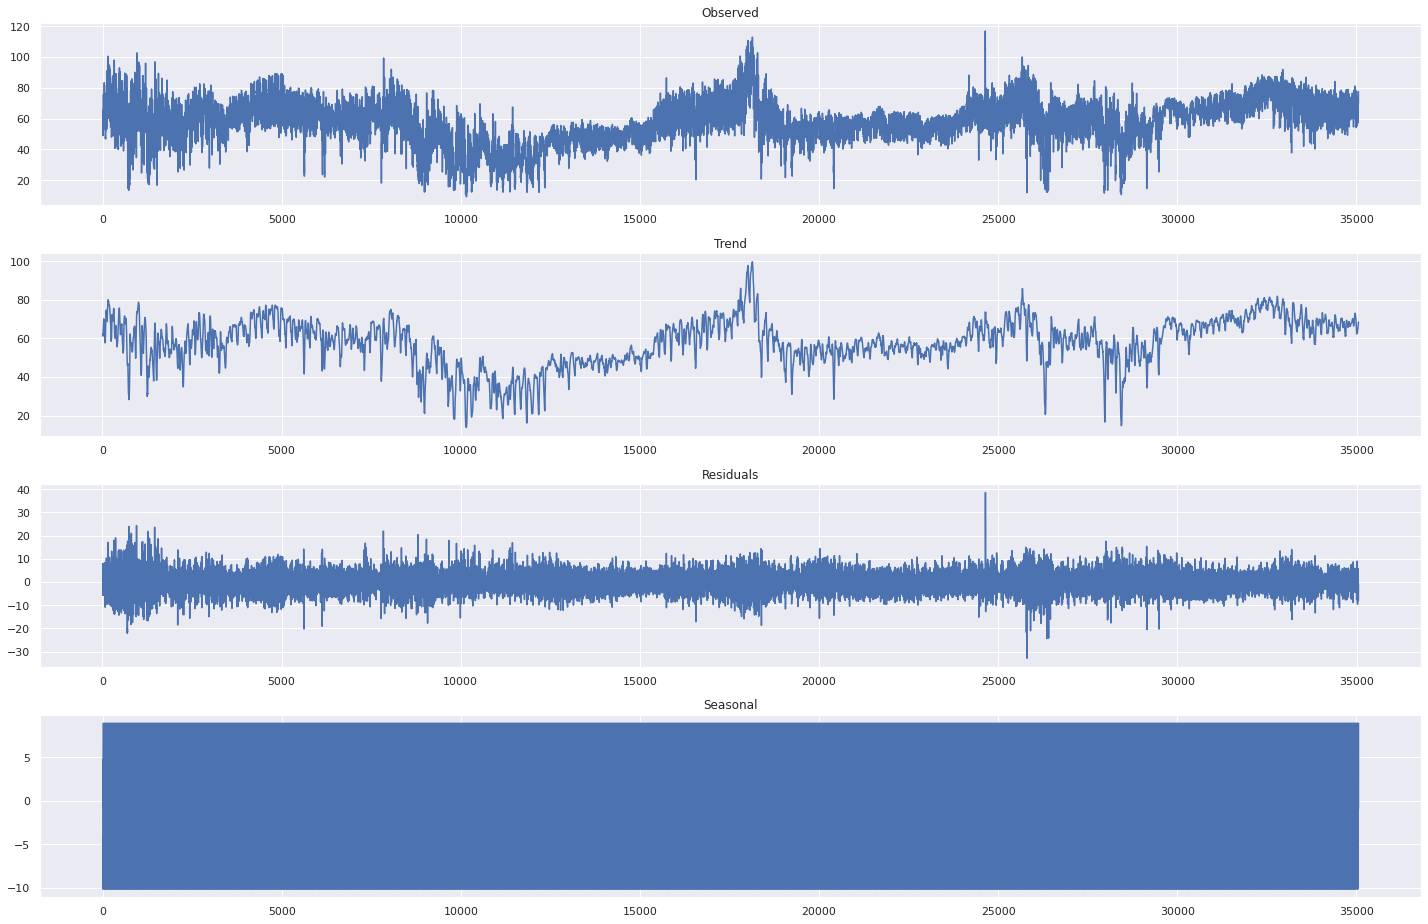

In [ ]:
season = sm.tsa.seasonal_decompose(data["price actual"], model = "additive", freq = 24) # Freq is necessary to bypass the bug in seasonal_decompose

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (20, 13))
season.observed.plot(ax = ax1, title = "Observed")
season.trend.plot(ax = ax2, title = "Trend")
season.resid.plot(ax = ax3, title = "Residuals")
season.seasonal.plot(ax = ax4, title = "Seasonal")
plt.tight_layout()
plt.show

### To make sure that the series is stationary I'll use the augmented dickey fuller test and the KPSS test.

It's a long time since I saw these names.

Since my statistics notes are horrible I made a small summary of the tests:

* ADF test: The null hypothesis (what I want to disprove) is that the series is not stationary.
  * I'll get a value, and if it's smaller than the critical value I will reject the null hypothesis.

* KPSS test: The null hypothesis is that the series is stationary.
  * I'll get a value and if it's higher than the critical value I will not be able to reject the null hypothesis.

In [ ]:
# ADF test

y = data["price actual"]
adf_test = adfuller(y, regression = "c") # Check with more regression parameters

print("ADF statistic = {:.2}\np-value = {:.2}\nLags used = {}".format(adf_test[0], adf_test[1], adf_test[2]))

for key, value in adf_test[4].items():
    print("Critical value ({}) = {:.2}".format(key, value))

ADF statistic = -9.1
p-value = 2.8e-15
Lags used = 50
Critical value (1%) = -3.4
Critical value (5%) = -2.9
Critical value (10%) = -2.6


For my series the ADF statistic is always below the critical value. I can reject the null hypothesis and say that the series is stationary around a constant

In [ ]:
# KPSS test

kpss_test = kpss(y, regression = "c", lags = "legacy")

print("KPSS statistic = {:.2f}\np-value = {:.2f}\nLags used = {:.2f}".format(kpss_test[0], kpss_test[1], kpss_test[2]))

for key, value in kpss_test[3].items():
    print("Critical value at {} = {:.2f}".format(key, value))
                                                                                                                


KPSS statistic = 7.96
p-value = 0.01
Lags used = 52.00
Critical value at 10% = 0.35
Critical value at 5% = 0.46
Critical value at 2.5% = 0.57
Critical value at 1% = 0.74


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


I see that the KPSS statistic is higher than the criticla value. I can't reject the hypothesis that states that my series is stationary.

## Autocorrelation and partial autocorrelation plots

I see that the hour price is correlated mostly with the previous 2 hours and with the 24-25 hours before. Makes a lot of sense to be honest, just look at the 2 week plot above.

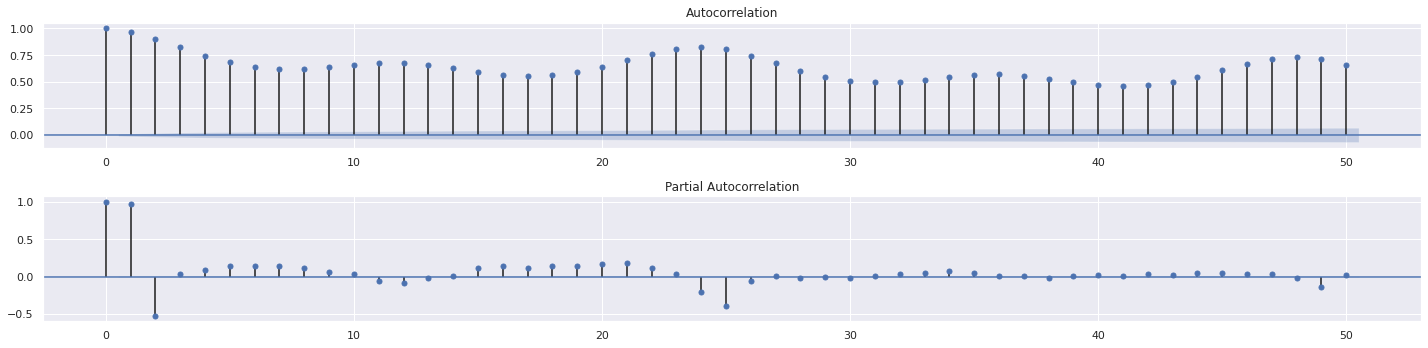

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize = (20, 5))

plot_acf(data["price actual"], lags = 50, ax = ax_1)
plot_pacf(data["price actual"], lags = 50, ax = ax_2)
plt.tight_layout()
plt.show()

### Correlation matrix

There are some variables that are correlated with one another, like the temperature in Valencia and Barcelona. Temperature is a smooth field, so no surprise here.

I will drop Snow 3h in Barcelona and Sevilla because they bring NaNs.

Then obviously the price actual and forecast are very correlated, also with the load. Additionally the load is correlated with the generation. This is due to the operation and the pool matching the previous day. Pablo is doing a good job :).

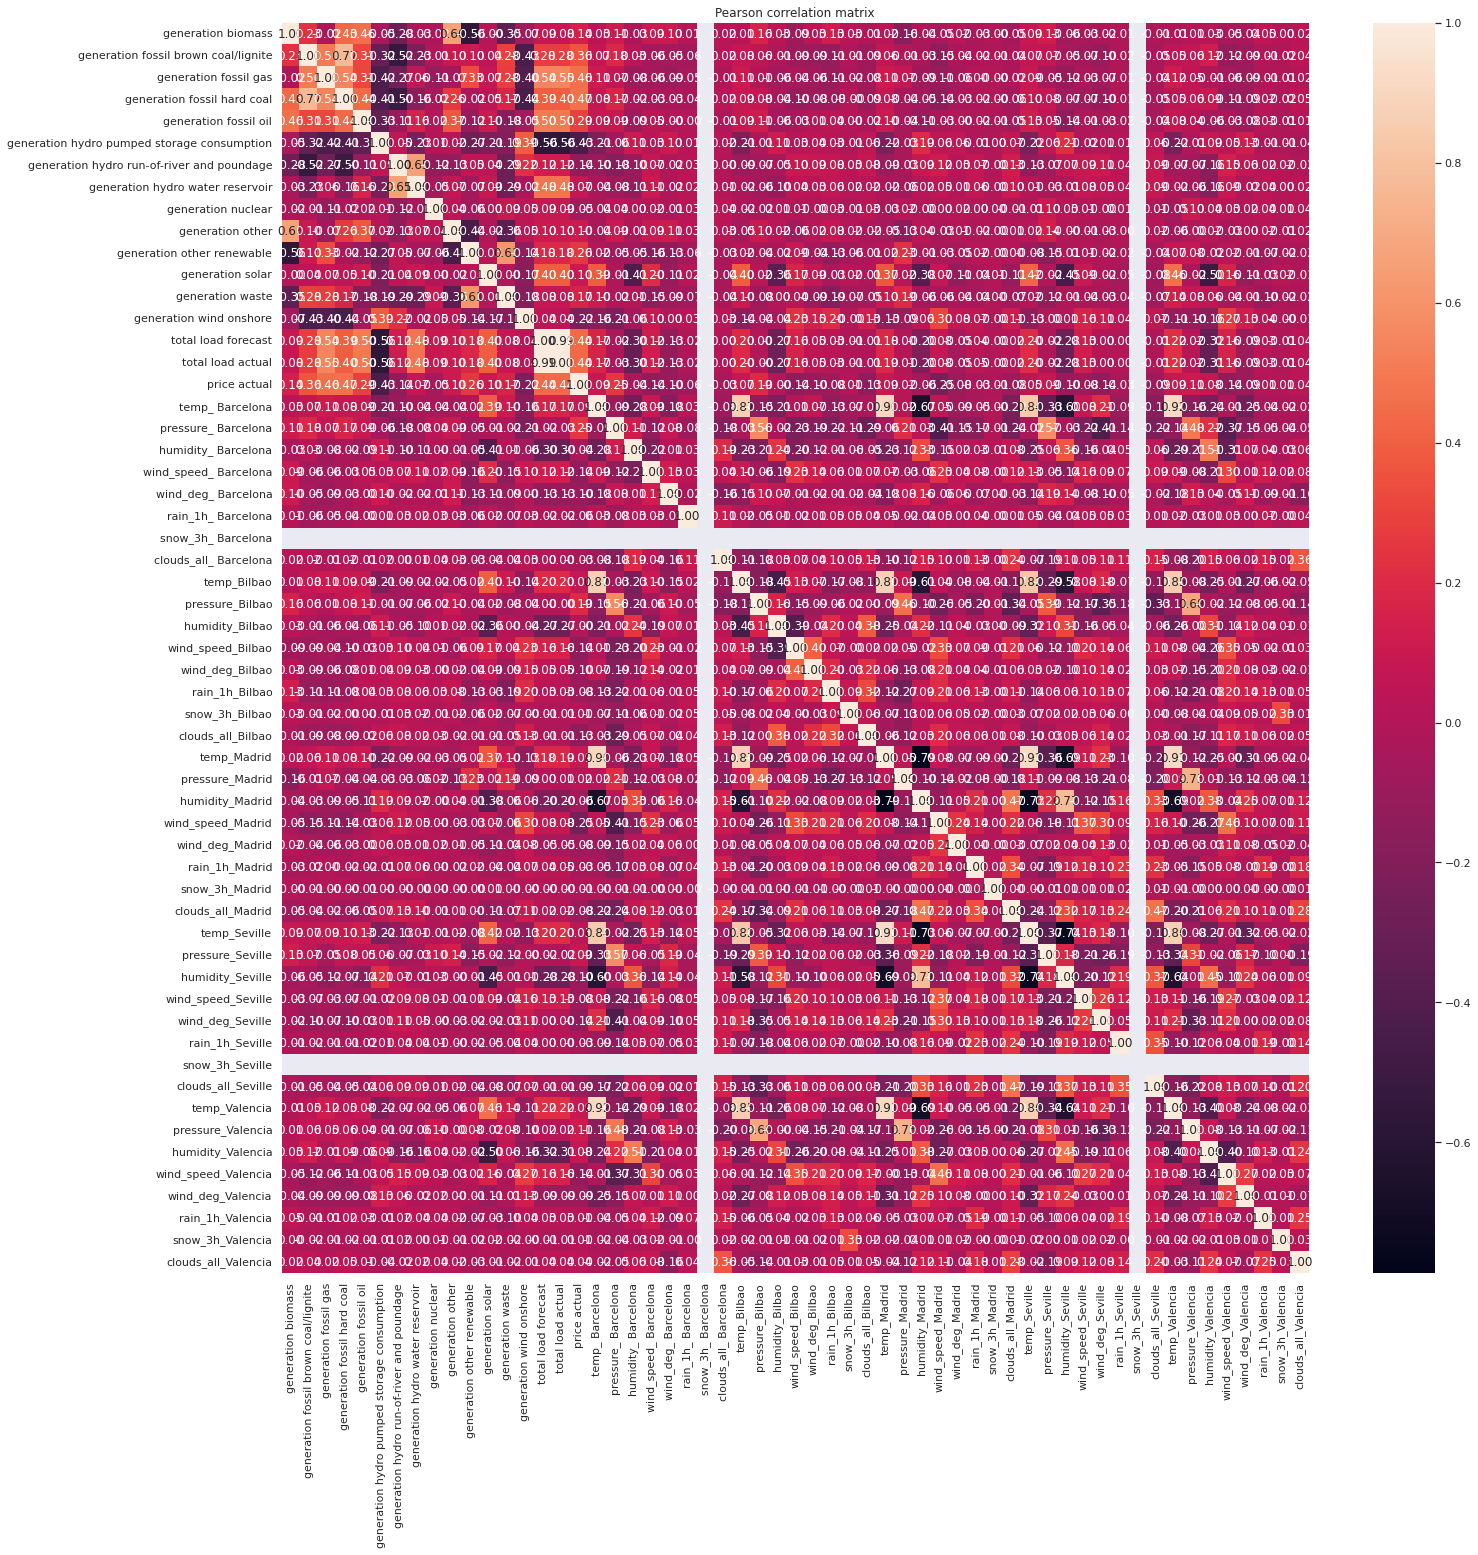

In [ ]:
correlations = data.corr(method = "pearson")

fig = plt.figure(figsize = (23,23))

sns.heatmap(correlations, annot = True, fmt = ".2f")
plt.title("Pearson correlation matrix")
plt.show()

In [ ]:
data.drop(labels = ["snow_3h_ Barcelona", "snow_3h_Seville"], axis = 1, inplace = True)
data.to_csv("/gdrive/MyDrive/Electricity_prices/for_features.csv", index = False)

## Et voilà!

Follow me for more awesome statistical tests.